### library, data 불러오기

In [0]:
import pandas as pd
import numpy as np
import time
import datetime
import random
import os
import matplotlib.pyplot as plt

In [0]:
target = pd.read_csv('data/target_v1.csv',parse_dates=True)
hsmp = pd.read_csv('data/hourly_smp_v1.csv',parse_dates=True)

In [0]:
lu = pd.read_csv('data/lookupTable_area.csv')
wth = pd.read_csv('data/weather_v1.csv',low_memory=False,parse_dates=True)

In [0]:
wth.index=wth.datetime

In [0]:
subformat = pd.read_csv('data/sample_submission.csv',parse_dates=True)

In [0]:
target.head()

,date,smp_max,smp_min,smp_mean,supply
0,2018-02-01,150.65,116.84,132.71,87.47
1,2018-02-02,163.86,116.84,134.19,86.64
2,2018-02-03,164.07,116.85,131.39,88.28
3,2018-02-04,171.00,115.76,131.89,86.14
4,2018-02-05,170.34,123.89,137.96,90.63


In [0]:
wth.head()

,area,datetime,temp,temp_QCFlag,prec,prec_QCFlag,ws,ws_QCFlag,wd,wd_QCFlag,...,vis,sfctype,weathernumber,sfctemp,sfctemp_QCFlag,landtemp_5cm,landtemp_10cm,landtemp_20cm,landtemp_30cm,station
datetime,,,,,,,,,,,,,,,,,,,,,
2018-02-01 01:00,184,2018-02-01 01:00,4.7,0.0,NaN,NaN,3.6,0.0,20.0,0.0,...,1950.0,NaN,NaN,2.9,0.0,3.7,3.9,4.2,4.9,ASOS
2018-02-01 02:00,184,2018-02-01 02:00,4.8,0.0,NaN,NaN,2.6,0.0,360.0,0.0,...,1865.0,NaN,NaN,2.9,0.0,3.6,3.8,4.2,4.9,ASOS
2018-02-01 03:00,184,2018-02-01 03:00,4.8,0.0,NaN,NaN,4.6,0.0,20.0,0.0,...,1855.0,NaN,NaN,3.0,0.0,3.6,3.8,4.3,4.9,ASOS
2018-02-01 04:00,184,2018-02-01 04:00,4.5,0.0,NaN,NaN,5.7,0.0,20.0,0.0,...,1425.0,NaN,NaN,3.0,0.0,3.6,3.8,4.2,5.0,ASOS
2018-02-01 05:00,184,2018-02-01 05:00,4.5,0.0,NaN,9.0,4.4,0.0,20.0,0.0,...,1043.0,NaN,1.0,3.0,0.0,3.5,3.8,4.2,4.9,ASOS


성산수산(area=892), 애월(893)은 기상데이터 적은 수 있음

### smp_max의 이상치 처리

In [0]:
target.loc[target.smp_max>300,:]# index169 =237.49; 540=599.28; 691=420.83

,date,smp_max,smp_min,smp_mean,supply
540,2019-07-26,599.28,149.58,184.80,86.26
691,2019-12-24,420.83,84.57,130.21,81.29


In [0]:
target_old=target.copy()

In [0]:
for outidx in [169,540,691]:
    oldval=target.loc[outidx,'smp_max']
    newval=target.loc[outidx-10:outidx,'smp_max'].mean()
    print(f'index {outidx}: {oldval} -> {newval}')
    target.loc[outidx,'smp_max']=newval

index 169: 237.49 -> 187.36272727272728
index 540: 599.28 -> 241.54363636363632
index 691: 420.83 -> 180.85


In [0]:
def plotY(target):
    plt.figure(figsize=(10,4))
    plt.scatter(target.index, target.smp_max, s=5, color='r', label='smp_max')
    plt.scatter(target.index, target.smp_min, s=5, color='b', label='smp_min')
    plt.scatter(target.index, target.smp_mean, s=5, color='black', label='smp_mean')
    plt.scatter(target.index, target.supply, s=5, color='purple', label='supply')
    plt.legend()
    plt.ylim((0,600))
    plt.show()

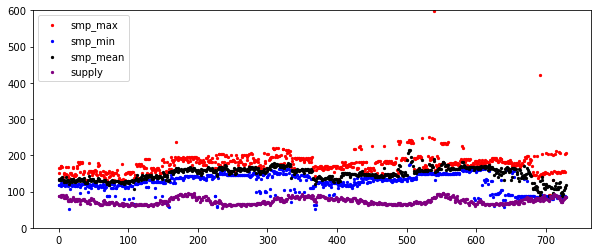

In [0]:
plotY(target_old)

이상치 제거됨 확인

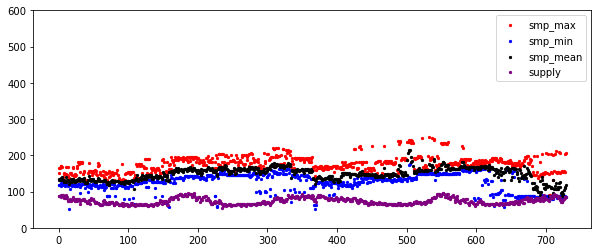

In [0]:
plotY(target)

### 데이터 변환: 일별 기상 변수 4개

'temp','ws','humid','prec' :기온, 풍속, 습도, 강수량

In [0]:
mywthfeatures=['temp','ws','humid','prec']

관심있는 feature의 QCFlag 빈도 확인 : 0(정상), 1(오류), 9(결측)

In [0]:
for myft in mywthfeatures:
    print(wth[myft+'_QCFlag'].value_counts())

0.0    27703
9.0       40
Name: temp_QCFlag, dtype: int64
0.0    26020
9.0      367
Name: ws_QCFlag, dtype: int64
0.0    27355
9.0       38
Name: humid_QCFlag, dtype: int64
9.0    14218
0.0     2837
Name: prec_QCFlag, dtype: int64


#### 시간 (행) x feature (열)인 dataframe으로 변환

In [0]:
df=pd.DataFrame(index=wth.datetime)
for myft in mywthfeatures:
    wth_by_hour_area=wth.pivot(index='datetime',columns='area',values=myft)
    wthmean_by_hour=wth_by_hour_area.mean(axis=1,skipna=True)
    # wthstd_by_hour=wth_by_hour_area.std(axis=1)
    df[myft]=wthmean_by_hour

In [0]:
df

,temp,ws,humid,prec
datetime,,,,
2018-02-01 01:00,0.745946,2.894444,75.324242,0.030303
2018-02-01 02:00,0.610811,2.630556,74.924242,0.000000
2018-02-01 03:00,0.624324,2.894444,74.857576,0.000000
2018-02-01 04:00,0.600000,3.122857,76.915152,0.000000
2018-02-01 05:00,0.621622,3.088889,77.836364,0.030303
...,...,...,...,...
2020-01-31 19:00,3.221053,3.794595,69.760000,0.000000
2020-01-31 20:00,3.128947,3.824324,69.962857,0.000000
2020-01-31 21:00,2.892105,3.659459,70.691429,0.000000


#### datetime 변수 저장

시간단위 datetime object 만들기 

2018-02-01 01:00:00 to 2020-01-31 23:00:00

In [0]:
dt_hours=wth.datetime.apply(lambda x :datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))

같은 길이의 일단위 datetime object 만들기

In [0]:
dt_dates=wth.datetime.str.replace(" ..:..$", "", regex=True)
dt_dates=dt_dates.apply(lambda x :datetime.datetime.strptime(x, '%Y-%m-%d'))

#### 일별 feature matrix 만들기 (24시간의 평균)

In [0]:
df['dates']=dt_dates

In [0]:
ft_bydate=df.groupby(['dates']).mean()

In [0]:
ft_bydate.head()

,temp,ws,humid,prec
dates,,,,
2018-02-01,1.271798,3.517856,67.423452,0.003274
2018-02-02,0.419820,3.851439,57.458586,0.000000
2018-02-03,-1.786653,5.614412,76.513073,0.287075
2018-02-04,-3.873874,5.976155,79.000126,0.269575
2018-02-05,-2.730006,5.134365,77.271397,0.241282


#### 1년 주기의 time_encoding 변수 만들기

In [0]:
dates=(ft_bydate.index.to_series()-datetime.datetime(2018, 1, 1))
dates_time_encoding= np.cos(2*np.pi*dates.dt.days/365)

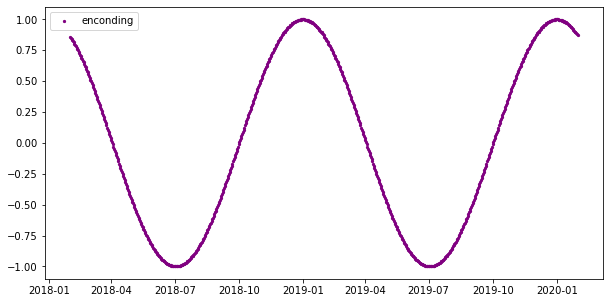

In [0]:
# plt.scatter(ft_bydate.index, dates, s=5, color='black', label='dates')
plt.figure(figsize=[10,5])
plt.scatter(dates_time_encoding.index, dates_time_encoding, s=5, color='purple', label='enconding')
plt.legend()
plt.show()

### 모델링

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

#### 데이터셋 loader
- X : 이전 28일치(t-27 ~ t) 4개 기상변수
- X.shape = (28,4)

- Y : 28일치(t+7 ~ t+35) 4개 종속변수 (일자별 전력수급실적 및 SMP 최대, 최소, 가중평균 데이터) 
- Y.shape = (28,4)

-     데이터 기간: 2018.02.01 ~ 2020.01.31 730일=26달
-     목적: 2020.02.07 ~ 2020.03.05 의 전력수요 및 SMP 예측 28일=1달 -> 2020-01-04~2020-01-31 집어넣음


In [0]:
xtestdata=np.hstack((ft_bydate.tail(28).values,target.iloc[:,1:].tail(n=28).values))

In [0]:
xtestdata.shape

(28, 8)

In [0]:
xtestdata_prep = scaler.transform(xtestdata)

In [0]:
xtestdata=xtestdata_prep.reshape((1,28,8))

In [0]:
wthdata=ft_bydate.copy()

In [0]:
wthdata.shape

(730, 4)

In [0]:
wthdata=wthdata.iloc[:730-28-7+5,:].values # 2018-02-01 ~ 2020-01-01, not 2019-12-27

In [0]:
targetdata_X=target.iloc[:730-28-7+5,1:].copy().values 

In [0]:
xdata=np.hstack((wthdata,targetdata_X))

In [0]:
# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
wthdata_prep = scaler.fit_transform(xdata)

In [0]:
wthdata_prep.shape

(700, 8)

In [0]:
wthdata=wthdata_prep.reshape((25,28,8))

In [0]:
wthdata.shape

(25, 28, 8)

In [0]:
targetdata=target.iloc[28+7-5:,1:].copy().values # 2018-03-03, not 2018-03-08 ~ 2020-01-31 

In [0]:
targetdata=targetdata.reshape((25,28,4))

In [0]:
targetdata.shape

(25, 28, 4)

In [0]:
targetdata[0].shape

(28, 4)

In [0]:
target.iloc[28+7-5:,1:]

,smp_max,smp_min,smp_mean,supply
30,180.97,113.75,133.78,73.19
31,154.19,94.96,128.29,65.10
32,180.00,119.48,135.75,76.46
33,181.06,120.72,134.07,76.67
34,180.18,120.76,132.96,77.36
...,...,...,...,...
725,154.46,78.95,94.07,76.64
726,156.57,84.80,103.05,80.25
727,154.78,86.99,109.21,82.90
728,203.15,84.87,112.85,84.85


In [0]:
# data_gen = TimeseriesGenerator(wthdata, targetdata,
#                                length=1, 
#                                stride=1,
#                                batch_size=1)

In [0]:
# def create_dataset(signal_data, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(signal_data)-look_back):
#         dataX.append(signal_data[i:(i+look_back), 0])
#         dataY.append(signal_data[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

In [0]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

# look_back = 40

In [0]:
# 데이터 분리
x_train = wthdata[0:20,:]
x_val = wthdata[20:23,:]
x_test = wthdata[23:,:]

In [0]:
y_train = targetdata[0:20,:]
y_val = targetdata[20:23,:]
y_test = targetdata[23:,:]

In [0]:
x_test.shape

(2, 28, 8)

In [0]:
# # 데이터셋 전처리
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [0]:
# 2. 모델 구성하기 
# Expected input batch shape: (batch_size N, timesteps 28, data_dim 8)
model = Sequential()
# for i in range(2):
#     model.add(LSTM(4, batch_input_shape=(1, 28, 8), stateful=True, return_sequences=True))
#     model.add(Dropout(0.3))
# model.add(LSTM(4, batch_input_shape=(1, 28, 4), stateful=True))
model.add(Dense(30, activation='relu', input_shape=(28, 8,)))
model.add(Dropout(0.3))
model.add(Dense(4))

In [0]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit_generator(data_gen, steps_per_epoch=1, epochs=10, verbose=1)

In [0]:
# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 23ms/step - loss: 19687.6262 - val_loss: 19285.0163
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 5ms/step - loss: 19646.4997 - val_loss: 19237.2090
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 19593.6769 - val_loss: 19171.4531
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 19518.9074 - val_loss: 19080.4635
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 5ms/step - loss: 19418.6783 - val_loss: 18960.0033
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 5ms/step - loss: 19286.4613 - val_loss: 18809.6042
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - los

20/20 [==============================] - 0s 4ms/step - loss: 1179.5830 - val_loss: 865.5301
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 1185.3226 - val_loss: 843.7569
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 1146.9880 - val_loss: 825.2475
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 1139.1388 - val_loss: 809.7214
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 1036.1396 - val_loss: 795.2792
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 1014.7408 - val_loss: 784.3922
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 1059.7970 - val_loss: 775.5595
Train on 20 samples, validate on 3 sam

20/20 [==============================] - 0s 4ms/step - loss: 921.8962 - val_loss: 697.3417
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 988.5010 - val_loss: 700.0644
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 872.0710 - val_loss: 701.5736
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 829.2050 - val_loss: 696.3341
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 971.6390 - val_loss: 690.1824
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 865.4880 - val_loss: 699.0646
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 913.8883 - val_loss: 693.4705
Train on 20 samples, validate on 3 samples
Ep

Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 854.9805 - val_loss: 660.8575
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 774.0136 - val_loss: 661.8795
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 856.5185 - val_loss: 664.8558
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 910.4762 - val_loss: 661.4196
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 841.8058 - val_loss: 660.5942
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 854.4591 - val_loss: 659.1631
Train on 20 samples, validate on 3 samples
Epoch 1/1
20/20 [==============================] - 0s 4ms/step - loss: 829.1487 - val_loss: 663.6157
Train on 20 samples, validate on 3 

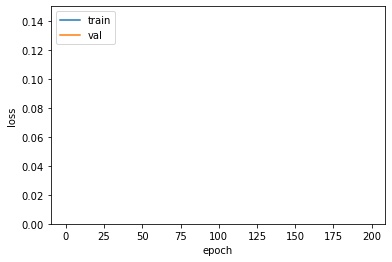

In [0]:
for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=True, callbacks=[custom_hist], validation_data=(x_val, y_val))
#     model.reset_states()

# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  438.69857635498045
Validataion Score:  647.3267822265625
Test Score:  754.2943725585938


In [0]:
y_test[0]

array([[199.44,  88.23, 160.68,  80.8 ],
       [179.37,  88.23, 151.54,  74.76],
       [176.7 ,  88.23, 153.32,  80.93],
       [191.04,  88.23, 145.43,  75.2 ],
       [180.72,  88.23, 148.62,  77.07],
       [188.45,  88.23, 141.82,  81.14],
       [169.18,  88.23, 122.79,  77.47],
       [146.9 ,  88.18, 107.72,  75.64],
       [152.63,  87.63, 109.63,  70.11],
       [196.99,  88.23, 124.52,  73.9 ],
       [145.51,  85.65, 107.8 ,  73.88],
       [146.37,  85.57, 113.87,  80.47],
       [146.32,  85.56, 115.52,  81.56],
       [197.87,  85.44, 113.8 ,  80.89],
       [153.66,  83.73, 104.44,  77.5 ],
       [138.02,  82.35,  99.62,  76.96],
       [144.25,  85.57,  99.13,  81.7 ],
       [180.85,  84.57, 130.21,  81.29],
       [146.35,  85.78,  91.86,  73.07],
       [148.89,  85.61,  98.85,  82.38],
       [204.7 ,  85.47, 138.92,  84.65],
       [143.94,  89.84, 131.05,  80.27],
       [151.05,  83.58, 121.39,  72.94],
       [149.26,  85.85, 111.14,  77.65],
       [151.84, 

In [0]:
model.predict(x_test)[0]

array([[181.51344 , 133.70616 , 154.07916 ,  75.09466 ],
       [150.8593  , 111.198105, 128.17331 ,  62.505066],
       [144.95456 , 106.849495, 123.179184,  60.08195 ],
       [150.01186 , 110.56755 , 127.48436 ,  62.19655 ],
       [162.99585 , 120.1133  , 138.46819 ,  67.495804],
       [146.31303 , 107.85727 , 124.380905,  60.681778],
       [145.65184 , 107.33568 , 123.80563 ,  60.416767],
       [145.49397 , 107.19953 , 123.60704 ,  60.27557 ],
       [158.82263 , 117.039444, 134.85449 ,  65.75885 ],
       [169.01814 , 124.55415 , 143.4685  ,  69.97043 ],
       [183.48586 , 135.17897 , 155.73935 ,  75.917076],
       [191.79373 , 141.22139 , 162.7302  ,  79.306305],
       [155.9152  , 114.89131 , 132.4618  ,  64.57501 ],
       [146.8784  , 108.25423 , 124.86929 ,  60.901485],
       [144.7396  , 106.68291 , 123.039246,  60.024105],
       [151.66129 , 111.805176, 128.9019  ,  62.900105],
       [150.12868 , 110.65242 , 127.570984,  62.262745],
       [157.40541 , 115.97601 ,

In [0]:
submittab=model.predict(xtestdata)

In [0]:
submittab1=submittab.reshape((28,4))

In [0]:
submittab=pd.DataFrame(submittab1,columns=subformat.columns[1:])

In [0]:
submittab2=pd.DataFrame(submittab1,index=subformat.index[28:],columns=subformat.columns[1:])

In [0]:
submittab.tail()

,smp_max,smp_min,smp_mean,supply
23,144.255264,106.158852,122.478333,59.778259
24,136.537872,100.603577,116.070427,56.685261
25,141.027359,103.893799,119.851440,58.496204
26,155.446304,114.412895,132.237091,64.461464
27,149.394424,109.983185,127.135658,61.970028


In [0]:
subm=subformat.copy()

In [0]:
subm.iloc[:28,1:]=submittab

In [0]:
subm.iloc[28:,1:]=submittab2

In [0]:
submittab2

,smp_max,smp_min,smp_mean,supply
28,124.817787,92.001732,106.070442,51.771683
29,135.404251,99.728447,115.222923,56.196987
30,139.593307,102.882233,118.552757,57.861610
31,135.542252,99.901169,114.815804,56.079132
32,130.404007,96.106873,110.538620,53.951557
33,137.285660,101.141830,116.662132,56.909351
34,141.364609,104.097015,120.316452,58.675636
35,128.251511,94.524734,109.007645,53.222294
36,125.681595,92.618797,106.720871,52.094898
37,153.861832,113.290306,130.918213,63.806438


In [0]:
subm

,date,smp_max,smp_min,smp_mean,supply
0,2020-02-07,124.817787,92.001732,106.070442,51.771683
1,2020-02-08,135.404251,99.728447,115.222923,56.196987
2,2020-02-09,139.593307,102.882233,118.552757,57.861610
3,2020-02-10,135.542252,99.901169,114.815804,56.079132
4,2020-02-11,130.404007,96.106873,110.538620,53.951557
5,2020-02-12,137.285660,101.141830,116.662132,56.909351
6,2020-02-13,141.364609,104.097015,120.316452,58.675636
7,2020-02-14,128.251511,94.524734,109.007645,53.222294
8,2020-02-15,125.681595,92.618797,106.720871,52.094898
9,2020-02-16,153.861832,113.290306,130.918213,63.806438


In [0]:
subm.to_csv('submit_200501.csv',index=False)